# RNN

Images from [cnvrg.io](https://cnvrg.io/pytorch-lstm/)
- Simple NN<BR>
![nn](https://cnvrg.io/wp-content/uploads/2020/12/Simple-Neural-Network.jpg)
- RNN<BR>
![rnn](https://cnvrg.io/wp-content/uploads/2020/12/Unfolding-RNNs.jpg)

RNN
- 현재 값(이전 step의 예측 값)과 이전 step의 hidden state를 통합하여 다음 예측값 및 현재에 대한 hidden state 도출
- hidden state
    1. $W_{hy}$: hidden state를 linear map을 통해 input dimension과 동일하게 변환
    2. $W_{hh}$:  hidden state를 linear map을 통해 hidden dimension과 동일하게 변환
        - hidden state를 업데이트해주는 방법을 포함하는 것
    
    - 모든 step에 대한 $W_{hy}, W_{hh}$는 동일한 layer
    
    => 사실상 거의 같은 녀석들. 동일한 vector를 서로 다른 linear map으로 매핑
- output: 2개 => 1) $\hat{y_t}$: 다음에 대한 예측 2) $W_{hh}$: 현재의 hidden state


## Auto-regression
$x_t$ : value
<!-- - input: $x_t = (a_{t-k+1}, a_{t-k+2}, \cdots, a_{t-1}, a_t)^T$ : k-dimension
- target: $y_t = (a_{t-k+2}, a_{t-k+3}, \cdots, a_t, a_{t+1})^T = x_{t+1}$ : k-dimension -->
- input: $x_t$
- target: $y_t = x_{t+1}$

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
print(sm.datasets.sunspots.NOTE)
data = sm.datasets.sunspots.load_pandas().data

data.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
data.index.freq = data.index.inferred_freq
del data["YEAR"]

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



## 다양한 데이터셋 구성 방법

1. 시계열 전체를 처음부터 외워서 다음을 맞추기
2. 이전 몇개를 보고 다음을 맞추기 (look-back window)

<Axes: >

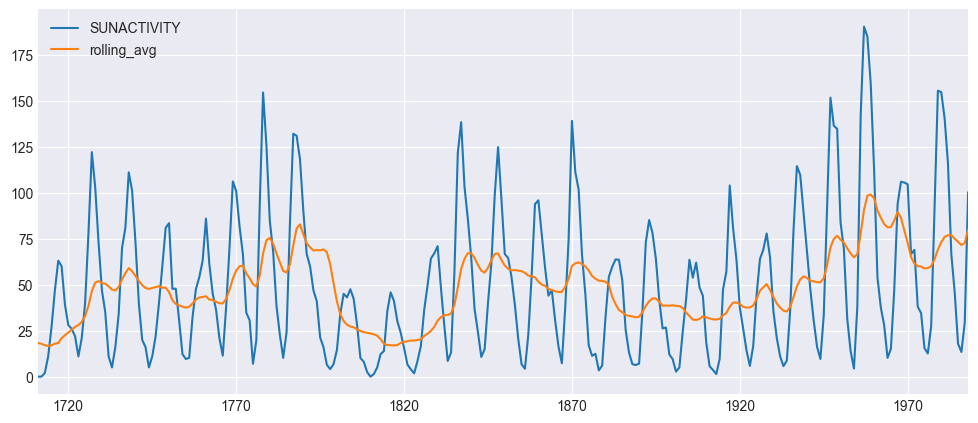

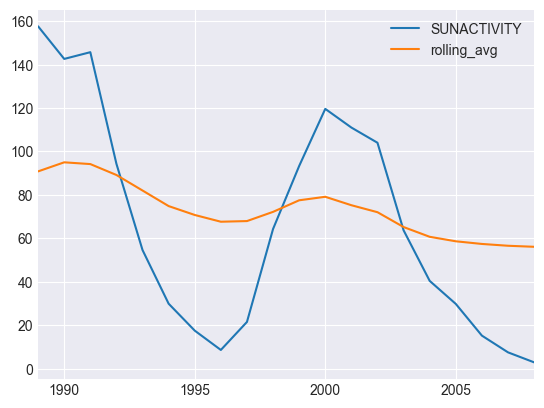

In [4]:
tst_size = 20

data_mw = data.copy()
data_mw['rolling_avg'] = data.SUNACTIVITY.rolling(12).mean()
data_mw = data_mw.dropna()

trn, tst = data_mw[:-tst_size], data_mw[-tst_size:]

scaler = MinMaxScaler()
scaler_ra = MinMaxScaler()

trn_scaled, tst_scaled = trn.copy(), tst.copy()

trn_scaled['SUNACTIVITY'] = scaler.fit_transform(trn.SUNACTIVITY.to_numpy(np.float32).reshape(-1,1))
trn_scaled['rolling_avg'] = scaler_ra.fit_transform(trn.rolling_avg.to_numpy(np.float32).reshape(-1,1))

tst_scaled['SUNACTIVITY'] = scaler.transform(tst.SUNACTIVITY.to_numpy(np.float32).reshape(-1,1))
tst_scaled['rolling_avg'] = scaler_ra.transform(tst.rolling_avg.to_numpy(np.float32).reshape(-1,1))

trn_scaled = trn_scaled.to_numpy(np.float32)
tst_scaled = tst_scaled.to_numpy(np.float32)

ax = trn.plot(figsize=(12,5))
tst.plot()

## LSTM
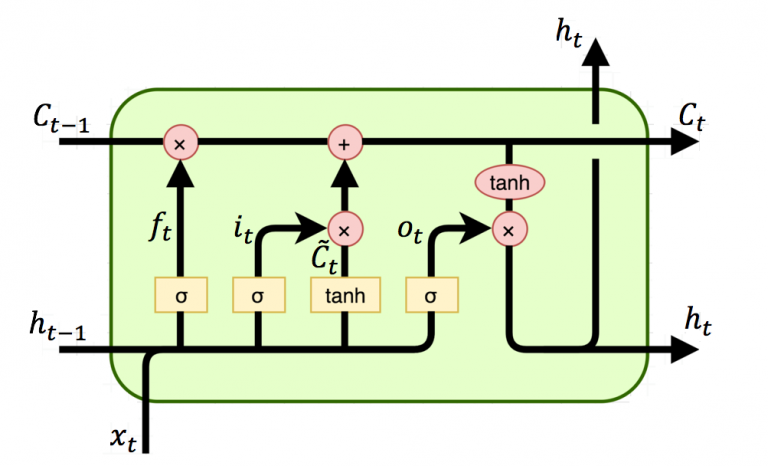
- 2개의 hidden state: 1) hidden state 2) memory(cell state)
- output과 hidden state가 정확히 동일




[torch.nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

`torch.nn.LSTM(self, input_size, hidden_size, num_layers=1, batch_first=True, proj_size=0)`

- `x`: output (aka hidden states), shape: `(batch_size, sequence_length, hidden_size)`
- `hn`: the final hidden state, shape: `(num_layers, batch_size, hidden_size)`
- `cn`: the final cell state, shape: `(num_layers, batch_size, hidden_size)`

In [78]:
x = torch.randn(32, 16*8, 2)
lstm = nn.LSTM(2, 64, 1, batch_first=True) #(input_dim_size, output_dim_size, num_layers)
x, (hn,cn) = lstm(x)

In [79]:
''' 
batch_size: 32
seq_len: 128
hidden_size: 64 (mapping input dim from 2 to 64)
'''
x.shape, hn.shape, cn.shape



(torch.Size([32, 128, 64]), torch.Size([1, 32, 64]), torch.Size([1, 32, 64]))

In [7]:
(x[:,-1,:].flatten() == hn.flatten()).all()

tensor(True)

### 전체 외우기
- No mini-batch
- model remembers the hidden states (stateful RNN)

In [8]:
class StatefulLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.reset_state()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
    self.head = nn.Linear(hidden_size, output_size)

  def reset_state(self, state=None):
    self.state = state

  def forward(self, x):
    assert x.dim() == 2   # (sequence_length, input_size)
    if self.state is None:
      x, (hn, cn) = self.rnn(x)   # state will be set to be zeros by default
    else:
      x, (hn, cn) = self.rnn(x, self.state)   # pass the saved state
    # x.shape == (sequence_length, hidden_size)
    self.reset_state((hn.detach(), cn.detach()))   # save the state
    x = self.head(x)  # (sequence_length, hidden_size) -> (sequence_length, output_size)
    return F.sigmoid(x)

  def predict(self, x0, steps, state=None):
    if state is not None:
      self.reset_state(state)
    output = []
    x = x0.reshape(1,-1)
    for i in range(steps): # 한 칸씩 옆으로 이동
      x = self.forward(x)
      output.append(x)
    return torch.concat(output, 0) #output의 맨 마지막 녀석들만 따오도록

In [9]:
batch_size = 64
trn_x = torch.tensor(trn_scaled[:-1]).split(batch_size)
trn_y = torch.tensor(trn_scaled[1:]).split(batch_size)

tst_y = torch.tensor(tst_scaled)

trn_x[0].shape, trn_y[0].shape

(torch.Size([64, 2]), torch.Size([64, 2]))

In [76]:
rnn = StatefulLSTM(2, 8, 2, 1)
rnn.to(device)

optim = torch.optim.AdamW(rnn.parameters(), lr=0.001)

pbar = trange(1000)
for e in pbar:
  rnn.train()
  rnn.reset_state() # 각 에폭마다 state를 reset해주어야 함.
  trn_loss = .0
  for x, y in zip(trn_x, trn_y):
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = rnn(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  rnn.eval()
  with torch.inference_mode():
    p = rnn.predict(y[-64:].to(device), len(tst_y)) # 마지막 1개를 넣어서 뒤에 20개를 예측
    tst_loss = F.mse_loss(p, tst_y.to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

  0%|          | 0/1000 [00:00<?, ?it/s]

In [53]:
def mape(input, target):
  return (np.abs(input - target)/target).mean() * 100

def mae(input, target):
  return np.abs(input - target).mean()

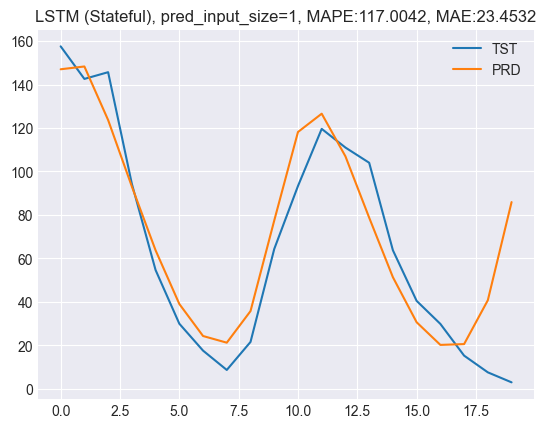

In [65]:
prd = scaler.inverse_transform(p.cpu()[:,:1])

plt.title(f"LSTM (Stateful), pred_input_size=1, MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}")
plt.plot(tst.SUNACTIVITY.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

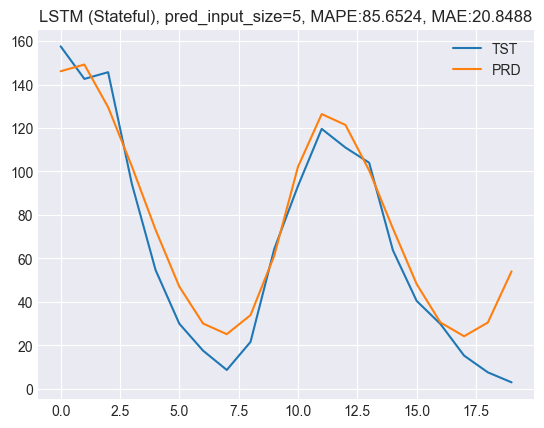

In [77]:
prd = scaler.inverse_transform(p.cpu()[:,:1])

plt.title(f"LSTM (Stateful), pred_input_size=5, MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}")
plt.plot(tst.SUNACTIVITY.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

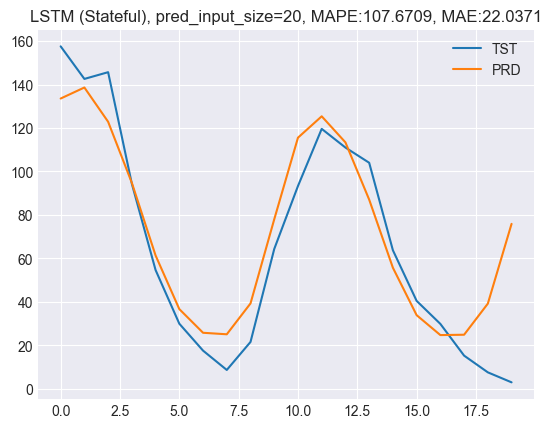

In [74]:
prd = scaler.inverse_transform(p.cpu()[:,:1])

plt.title(f"LSTM (Stateful), pred_input_size=20, MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}")
plt.plot(tst.SUNACTIVITY.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

### Transformer 대비 잘 사용되지 않는 이유?
- train이 운빨임
- layer를 깊게 만들어도 수렴이 어려움
- 오차 중첩으로 인해 최종 값이 어그러지기 쉬움
    - dropout, scaler, normalize, scheduler 등 학습 전략을 잘 짜주어야 할 필요가 있음
    - 데이터 전처리 과정이 굉장히 중요할 수 있다.
    

## Look-back Window

In [80]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, shift_size:int):
    self.lookback_size = lookback_size
    self.shift_size = shift_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.shift_size + 1

  def __getitem__(self, i):
    idx = (i+self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[i+self.shift_size:idx+self.shift_size]

    return look_back, forecast

In [86]:
window_size = 5

# input_dim=6으로 구성(원래 seq에서 입력 5개(x_t ~ x_t-1, ... x_t-4), window avg 1개)

trn_ds = TimeSeriesDataset(trn_scaled, window_size, 1)
tst_ds = TimeSeriesDataset(np.concatenate([trn_scaled[-window_size:], tst_scaled], axis=0), window_size, 1)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=64, shuffle=False)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=len(tst_ds), shuffle=False)

In [92]:
x, y = next(iter(tst_dl))
x.shape, y.shape

(torch.Size([20, 5, 2]), torch.Size([20, 5, 2]))

In [93]:
class StatelessLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.head = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x, _ = self.rnn(x)   # state will be set to be zeros by default
    # x.shape == (batch_size, sequence_length, hidden_size)
    x = self.head(x)  # (batch_size, sequence_length, output_size)
    return F.sigmoid(x)

  def predict(self, x, steps, state=None):
    output = []
    for i in range(steps):
      x = self.forward(x)
      output.append(x[-1:])
    return torch.concat(output, 0)

In [94]:
rnn = StatelessLSTM(2, 8, 2, 2)
rnn.to(device)

x, y = next(iter(tst_dl))
rnn.predict(x[0].to(device), 20).shape

torch.Size([20, 2])

In [95]:
rnn = StatelessLSTM(2, 8, 2, 2)
rnn.to(device)

optim = torch.optim.AdamW(rnn.parameters(), lr=0.001)

pbar = trange(1000)
for e in pbar:
  rnn.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = rnn(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  rnn.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    p = rnn.predict(x[0].to(device), len(tst_scaled))[:,:1]
    tst_loss = F.mse_loss(p, torch.tensor(tst_scaled[:,:1]).view(-1,1).to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

  0%|          | 0/1000 [00:00<?, ?it/s]

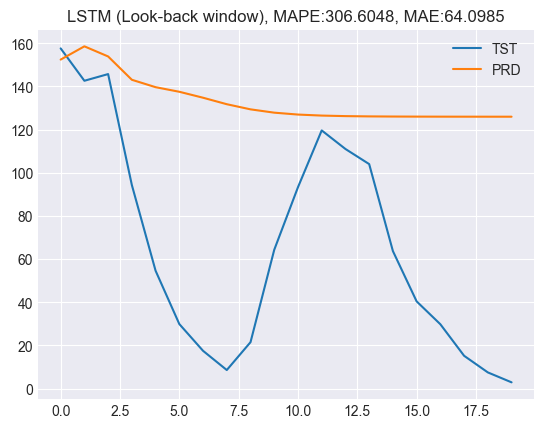

In [91]:
prd = scaler.inverse_transform(p.cpu())
# prd = p.cpu()

plt.title(f"LSTM (Look-back window), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}")
plt.plot(tst.to_numpy()[:,:1], label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

### 결과
- Stateful LSTM에 비해 좋지 않은 결과를 보임
- why? 
    - shuffle함으로써 전체 데이터가 아닌 단순히 64개의 연속된 데이터만을 봄 
    
    -> 64개로 묶인 데이터들에 다양한 패턴이 들어가있어야 효과적으로 학습이 가능

- 언제 쓰지?
    - sequence 길이가 말도 안되게 길다면?(ex. 2시간짜리 녹음본, 60Hz 센서 등) 
    
    -> 어쩔 수 없이 잘라서 써야 함